# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I will use the tools such as color selection, region of interest ,grayscaling, region of interest, Canny Edge and Hough transformation method to find lanes on the road.  I will develop my  pipeline on a series of individual images, and later apply the result to a video stream .

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


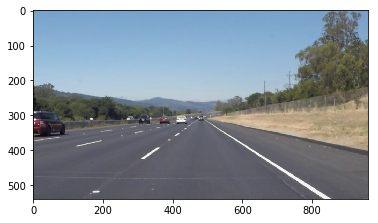

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

## Ideas for Lane Detection Pipeline

**Some OpenCV functions used in this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image



## Helper Functions

Below are some helper functions that I will use in this project

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img,lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Below this, I will build the  pipeline to work on the images in the directory "test_images"  

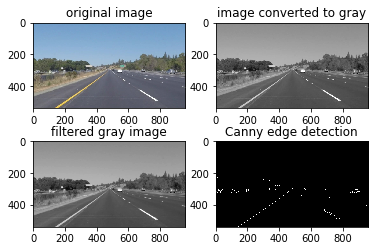

In [4]:
import os
images = os.listdir("test_images/")
# this n=0:6 , can be changed to change the image 
n=5
image = mpimg.imread('test_images/{}'.format(images[n]))

plt.subplot(2,2,1)
plt.imshow(image)  
plt.title('original image')

#converting the image to grayscale
gray = grayscale(image)
plt.subplot(2,2,2)
plt.imshow(gray,cmap='gray')
plt.title('image converted to gray')

#filtering the image using gaussian filter
kernel = 5
blur_gray = gaussian_blur(gray,kernel)
plt.subplot(2,2,3)
plt.imshow(blur_gray,cmap='gray')
plt.title('filtered gray image')

# applying canny edge detection algorithm to detect edges 
low_threshold_canny = 100
high_threshold_canny = 300
edges = canny(blur_gray,low_threshold_canny,high_threshold_canny)
plt.subplot(2,2,4)
plt.imshow(edges,cmap='gray')
plt.title('Canny edge detection')

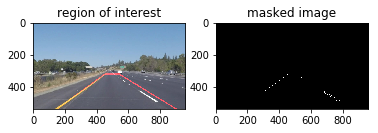

In [5]:
#applying the region of interest to select the region where left and right lane lies and to eliminate outliers

x_size = image.shape[1]
y_size = image.shape[0]
point1 = [150,y_size]
point2 = [x_size-60,y_size]
point3 = [450,320]
point4 = [540,320]
vertices = np.array([[point1,point3,point4,point2]]) 

# vertices lines is the region of interest formed by lines
vertices_lines=np.array([[[point1[0],point1[1],point2[0],point2[1]],[point3[0],point3[1],point4[0],point4[1]],\
                         [point1[0],point1[1],point3[0],point3[1]],\
                        [point2[0],point2[1],point4[0],point4[1]]]],dtype=np.int32)

# masked image is the image in which lanes only lie in the region of interest and everything outside the region  is eliminated.                  
masked_image=region_of_interest(edges,vertices) 

# a red polygon showing region of interest is shown on original image
draw_poly_image=np.zeros((masked_image.shape[0], masked_image.shape[1],3), dtype=np.uint8)
draw_lines(draw_poly_image,vertices_lines,color=[255,0,0],thickness=5)
poly_image=weighted_img(image, draw_poly_image, α=.7, β=1., λ=0.)

plt.subplot(2,2,1)
plt.imshow(poly_image)
plt.title('region of interest')
plt.subplot(2,2,2)
plt.imshow(masked_image,cmap='gray')
plt.title('masked image')


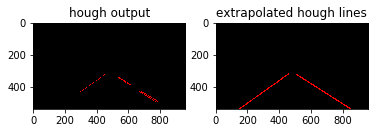

In [6]:
# Hough tranformation will be applied on masked edge to find the possible lane lines in the masked image 
# 'lines' are the potential lines making left and right lane
rho=2
theta=np.pi/180
threshold=20
min_line_length=10
max_line_gap=40
line_image,lines=hough_lines(masked_image,rho, theta, threshold, min_line_length, max_line_gap)


# code below categorizes the lines making left lane and right lane. 
#slope_positive makes right  lane and slope_negtive makes left lane 
slope_lines=(lines[:,:,3]-lines[:,:,1])/(lines[:,:,2]-lines[:,:,0])
slope_positive=(slope_lines>0)&(lines[:,:,0]>400)&(lines[:,:,2]>400)
slope_negative=(slope_lines<0)&(lines[:,:,0]<550)&(lines[:,:,0]<550)


#Extrapolated_line_coordinates function fits a  single best fit line  through all the existing lines either making  right lane or left lane 
#ymin and ymax are the first and last y coordinates for the line 
def Extrapolated_line_coordinates(slope_sign,lines,y_min,y_max):
    x_slope_points=np.concatenate((lines[slope_sign][:,0],lines[slope_sign][:,2]),axis=0)
    y_slope_points=np.concatenate((lines[slope_sign][:,1],lines[slope_sign][:,3]),axis=0)
    slope_linecoeff = np.polyfit(x_slope_points,y_slope_points,1)
    slope=slope_linecoeff[0]
    slope_intersect=slope_linecoeff[1]
    y0=y_min
    y1=y_max
    x0=(y0-slope_intersect)/slope
    x1=(y1-slope_intersect)/slope
    return x0, y0,x1,y1

# choosing the first and last coordinates for the extrapolated lines. 
y_min=point3[1]
y_max=y_size

# the following code uses Extrapolated_line_coordinates funcation to  find the first and last x-y coordinates
#for left as well as right lane 

[x0_pos,y0_pos,x1_pos,y1_pos]=Extrapolated_line_coordinates(slope_positive,lines,y_min,y_max)# right lane coordinates 
[x0_neg,y0_neg,x1_neg,y1_neg]=Extrapolated_line_coordinates(slope_negative,lines,y_min,y_max)# left lane coordinates 

# the left and right lanes are drawn with red color on the zero image with original image size 
lines_interpolated=np.array([[[x0_pos,y0_pos,x1_pos,y1_pos],[x0_neg,y0_neg,x1_neg,y1_neg]]],dtype=np.int32)
line_img_interpolated=np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8)
draw_lines(line_img_interpolated, lines_interpolated,color=[255, 0, 0], thickness=5)

plt.subplot(2,2,1)
plt.imshow(line_image)
plt.title ('hough output')

plt.subplot(2,2,2)
plt.imshow(line_img_interpolated)
plt.title ('extrapolated hough lines')

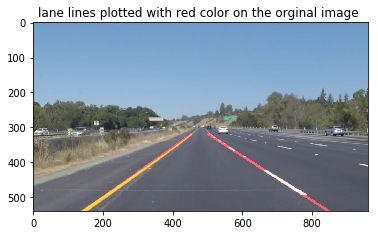

In [7]:
# extrapolated hough output lines plotted on the original image
line_edges= weighted_img(line_img_interpolated, image, α=1, β=.8, λ=0.)
plt.imshow(line_edges)
plt.title('lane lines plotted with red color on the orginal image ')
                                                                    

## Build a Lane Finding Pipeline



Now, I will run the above defined algorithm on all test images and save them in test_images output folder.

In [8]:
output_image=cv2.imwrite('test_images_output/{}'.format(images[n]),line_edges[...,[2,1,0]])

## Test on Videos

Testing the above defined algorithm on videos 

In [9]:
# Importing libraries needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    gray = grayscale(image)
    kernel = 5
    blur_gray = gaussian_blur(gray,kernel)
    low_threshold_canny = 100
    high_threshold_canny = 300
    edges = canny(blur_gray,low_threshold_canny,high_threshold_canny)
    x_size = image.shape[1]
    y_size = image.shape[0]
    point1 = [150,y_size]
    point2 = [x_size-60,y_size]
    point3 = [450,320]
    point4 = [540,320]
    vertices = np.array([[point1,point3,point4,point2]])
    masked_image=region_of_interest(edges,vertices)
    rho=2
    theta=np.pi/180
    threshold=20
    min_line_length=10
    max_line_gap=40
    line_image,lines=hough_lines(masked_image,rho, theta, threshold, min_line_length, max_line_gap)
    slope_lines=(lines[:,:,3]-lines[:,:,1])/(lines[:,:,2]-lines[:,:,0])
    slope_positive=(slope_lines>0)&(lines[:,:,0]>400)&(lines[:,:,2]>400)
    slope_negative=(slope_lines<0)&(lines[:,:,0]<550)&(lines[:,:,0]<550)
    y_min=point3[1]
    y_max=y_size

    [x0_pos,y0_pos,x1_pos,y1_pos]=Extrapolated_line_coordinates(slope_positive,lines,y_min,y_max)
    [x0_neg,y0_neg,x1_neg,y1_neg]=Extrapolated_line_coordinates(slope_negative,lines,y_min,y_max)
    lines_interpolated=np.array([[[x0_pos,y0_pos,x1_pos,y1_pos],[x0_neg,y0_neg,x1_neg,y1_neg]]],dtype=np.int32)
    line_img_interpolated=np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img_interpolated, lines_interpolated,color=[255, 0, 0], thickness=5)
    line_edges= weighted_img(line_img_interpolated, image, α=1, β=1, λ=0.)
    return line_edges

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process I may want to try my pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## I may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:11<00:00, 18.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.05 s, sys: 296 ms, total: 3.34 s
Wall time: 13.2 s


Playing the video inline

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. 

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:45<00:00, 12.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.49 s, sys: 980 ms, total: 10.5 s
Wall time: 47.3 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:35<00:00,  7.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.13 s, sys: 688 ms, total: 6.82 s
Wall time: 39.4 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))